In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


In [2]:
# !pip install bcolz

In [3]:
# import bcolz
import csv
import torch
import transformers
import sys
import os
import pickle
import spacy
import seaborn as sns
import textblob
import string
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')


import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import linear_model
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import sklearn
from sklearn.model_selection import train_test_split

In [4]:
TFIDF_MAX_FEATURES = 5000
GLOVE_DIMENSIONS = 100
GLOVE_INPUT_PATH = "../input/glove6b"
GLOVE_OUTPUT_PATH = "./glove6b"
GLOVE_VERSION = "glove.6B.100d"

In [5]:
if not os.path.exists("glove6b"):
    os.makedirs("glove6b")

In [6]:
full_dataset_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")

# Data exploration

In [7]:
full_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB


In [8]:
full_dataset_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [9]:
full_dataset_df["tokenized_excerpt"] = full_dataset_df["excerpt"].apply(lambda x: word_tokenize(x))
full_dataset_df["sentences_in_excerpt"] = full_dataset_df["excerpt"].apply(lambda x: sent_tokenize(x))

test_df["tokenized_excerpt"] = test_df["excerpt"].apply(lambda x: word_tokenize(x))
test_df["sentences_in_excerpt"] = test_df["excerpt"].apply(lambda x: sent_tokenize(x))

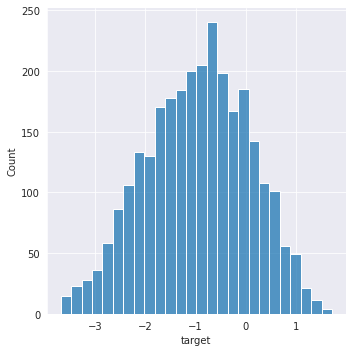

In [10]:
sns.set_style('darkgrid')
sns.displot(full_dataset_df["target"])

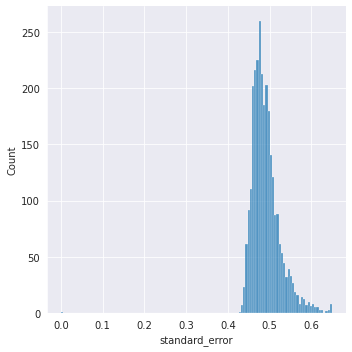

In [11]:
sns.displot(full_dataset_df["standard_error"])

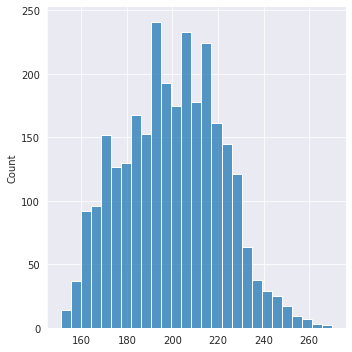

In [12]:
sns.displot(np.array([len(x) for x in full_dataset_df["tokenized_excerpt"]]))

# Prepare the dataset

In [13]:
# Temporarily disabled - train / test split will be moved to later stages
# I will not introduce the split right now, in favour of K-folds later
# training_dataset, validation_dataset = train_test_split(train_df, test_size=0.25, train_size=0.75)

### Count vectorization

In [14]:
count_vectorizer = CountVectorizer(analyzer='word')

def generate_count_vectors(dataset):
    count_vectorizer.fit(dataset['excerpt'])
    count_vectors =  count_vectorizer.transform(dataset["excerpt"])
    return count_vectors

def generate_count_df(dataset, count_vectors):
    return pd.DataFrame(count_vectors.toarray(), index=dataset['id'].values, columns=count_vectorizer.get_feature_names())

### TF-IDF Vectorization

In [15]:
class TFIDF_settings:    
    class word_level:
        max_features = TFIDF_MAX_FEATURES
        analyzer = "word"
        ngram_range = (1,1)
    
    class ngram_level:
        max_features = TFIDF_MAX_FEATURES
        analyzer = "word"
        ngram_range = (2,3)
    
    class character_level:
        max_features = TFIDF_MAX_FEATURES
        analyzer = "char"
        ngram_range = (2,3)

        
def generate_tfidf_vectors(dataset, settings):
    tfidf_vectorizer = TfidfVectorizer(analyzer=settings.analyzer, ngram_range=settings.ngram_range, max_features=settings.max_features)
    tfidf_vectorizer.fit(dataset['excerpt'])
    dataset_tfidf =  tfidf_vectorizer.transform(dataset["excerpt"])
    return dataset_tfidf

In [16]:
tfidf_vectors_word_level = generate_tfidf_vectors(dataset=full_dataset_df, settings=TFIDF_settings.word_level)
tfidf_vectors_ngram_level = generate_tfidf_vectors(dataset=full_dataset_df, settings=TFIDF_settings.ngram_level)
tfidf_vectors_character_level = generate_tfidf_vectors(dataset=full_dataset_df, settings=TFIDF_settings.character_level)

### Word embeddings - GloVe

In [17]:
# if not ( os.path.exists(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}.dat') and os.path.exists(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}_words.pkl') and os.path.exists(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}_idx.pkl') ):
#     embedding_dict={}
#     with open(f'{GLOVE_INPUT_PATH}/{GLOVE_VERSION}.txt','r', encoding='utf8') as f:
#         for line in f:
#             values=line.split()
#             word=values[0]
#             vectors=np.asarray(values[1:],'float32')
#             embedding_dict[word]=vectors
#     f.close()

#     words = []
#     idx = 0
#     word2idx = {}
#     vectors = bcolz.carray(np.zeros(1), rootdir=f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}.dat', mode='w')

#     with open(f'{GLOVE_INPUT_PATH}/{GLOVE_VERSION}.txt', 'rb') as f:
#         for l in f:
#             line = l.decode().split()
#             word = line[0]
#             words.append(word)
#             word2idx[word] = idx
#             idx += 1
#             vect = np.array(line[1:]).astype(np.float)
#             vectors.append(vect)

#     vectors = bcolz.carray(vectors[1:].reshape((400000, GLOVE_DIMENSIONS)), rootdir=f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}.dat', mode='w')
#     vectors.flush()
#     pickle.dump(words, open(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}_words.pkl', 'wb'))
#     pickle.dump(word2idx, open(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}_idx.pkl', 'wb'))
    
# else:
#     vectors = bcolz.open(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}.dat')[:]
#     words = pickle.load(open(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}_words.pkl', 'rb'))
#     word2idx = pickle.load(open(f'{GLOVE_OUTPUT_PATH}/{GLOVE_VERSION}_idx.pkl', 'rb'))
    
# glove = {w: vectors[word2idx[w]] for w in words}

I create an embedding for every paragraph by averaging all of its embeddings. I am not sure whether that's correct, but my hopes are that those embeddings will be usable in simpler, non-NN ML methods. 

In [ ]:
# TODO 

Also, I will add a number of experimental features. I hypothesize that proportions of parts of speech, word density etc. may be indicative of text's readability and complexity. 

In [18]:
def add_experimental_features(dataset):
    dataset['char_count'] = dataset['excerpt'].apply(len)
    dataset['word_count'] = dataset['excerpt'].apply(lambda x: len(x.split()))
    dataset['word_density'] = dataset['char_count'] / (dataset['word_count']+1)
    dataset['sentence_count'] = dataset['sentences_in_excerpt'].apply(len)
    dataset['sentence_average_lenght'] = dataset['char_count'] / (dataset['sentence_count']+1)    
    dataset['punctuation_count'] = dataset['excerpt'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    dataset['title_word_count'] = dataset['excerpt'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    dataset['upper_case_word_count'] = dataset['excerpt'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    
    pos_family = {
        'noun' : ['NN','NNS','NNP','NNPS'],
        'pron' : ['PRP','PRP$','WP','WP$'],
        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
        'adj' :  ['JJ','JJR','JJS'],
        'adv' : ['RB','RBR','RBS','WRB']
    }

    # function to check and get the part of speech tag count of a words in a given sentence
    def check_pos_tag(x, flag):
        cnt = 0
        try:
            wiki = textblob.TextBlob(x)
            for tup in wiki.tags:
                ppo = list(tup)[1]
                if ppo in pos_family[flag]:
                    cnt += 1
        except:
            pass
        return cnt

    dataset['noun_count'] = dataset['excerpt'].apply(lambda x: check_pos_tag(x, 'noun'))
    dataset['verb_count'] = dataset['excerpt'].apply(lambda x: check_pos_tag(x, 'verb'))
    dataset['adj_count'] = dataset['excerpt'].apply(lambda x: check_pos_tag(x, 'adj'))
    dataset['adv_count'] = dataset['excerpt'].apply(lambda x: check_pos_tag(x, 'adv'))
    dataset['pron_count'] = dataset['excerpt'].apply(lambda x: check_pos_tag(x, 'pron'))
    
    return dataset
    
full_dataset_df = add_experimental_features(full_dataset_df)

In [19]:
test_df = add_experimental_features(test_df)

In [20]:
full_dataset_df

,id,url_legal,license,excerpt,target,standard_error,tokenized_excerpt,sentences_in_excerpt,char_count,word_count,...,sentence_count,sentence_average_lenght,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,"[When, the, young, people, returned, to, the, ...",[When the young people returned to the ballroo...,992,179,...,11,82.666667,27,16,0,48,34,13,6,4
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,"[All, through, dinner, time, ,, Mrs., Fayre, w...","[All through dinner time, Mrs. Fayre was somew...",937,169,...,15,58.562500,56,28,6,30,38,12,17,29
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,"[As, Roger, had, predicted, ,, the, snow, depa...","[As Roger had predicted, the snow departed as ...",908,166,...,11,75.666667,47,29,2,41,32,10,20,21
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,"[And, outside, before, the, palace, a, great, ...",[And outside before the palace a great garden ...,909,164,...,5,151.500000,33,8,0,52,19,16,2,12
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,"[Once, upon, a, time, there, were, Three, Bear...",[Once upon a time there were Three Bears who l...,723,147,...,5,120.500000,32,42,0,51,10,13,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,"[When, you, think, of, dinosaurs, and, where, ...",[When you think of dinosaurs and where they li...,901,145,...,13,64.357143,25,23,0,41,31,10,8,9
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,"[So, what, is, a, solid, ?, Solids, are, usual...","[So what is a solid?, Solids are usually hard ...",890,164,...,14,59.333333,19,14,1,32,31,16,17,11
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,"[The, second, state, of, matter, we, will, dis...",[The second state of matter we will discuss is...,949,190,...,17,52.722222,25,17,0,50,32,9,8,14
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,"[Solids, are, shapes, that, you, can, actually...",[Solids are shapes that you can actually touch...,864,150,...,12,66.461538,32,15,1,38,31,18,6,8


## Choose columns that will be used

In [21]:
# choose columns
training_dataset_X = full_dataset_df.loc[:,['char_count', 'word_count', 'word_density',
       'punctuation_count', 'title_word_count', 'upper_case_word_count',
       'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count',
       'sentence_count', 'sentence_average_lenght']]
training_dataset_Y = full_dataset_df.loc[:,['target']]
test_dataset_X = test_df.loc[:,['char_count', 'word_count', 'word_density',
       'punctuation_count', 'title_word_count', 'upper_case_word_count',
       'noun_count', 'verb_count', 'adj_count', 'adv_count', 'pron_count',
       'sentence_count', 'sentence_average_lenght']]

training_dataset_X = training_dataset_X.set_index(full_dataset_df["id"])
training_dataset_Y = training_dataset_Y.set_index(full_dataset_df["id"])
test_dataset_X = test_dataset_X.set_index(test_df["id"])


## Normalization

In [22]:
# Shouldn't I use a different scaler?
min_max_scaler_X = MinMaxScaler()
min_max_scaler_Y = MinMaxScaler()

training_dataset_X_scaled = min_max_scaler_X.fit_transform(training_dataset_X)
training_dataset_Y_scaled = min_max_scaler_Y.fit_transform(training_dataset_Y)

test_dataset_X_scaled = min_max_scaler_X.transform(test_dataset_X)

# min_max_scaler_Y.fit(training_dataset.loc[:,"target"].to_numpy().reshape(-1,1))

In [23]:
training_dataset_X_scaled = pd.DataFrame(training_dataset_X_scaled, index=full_dataset_df["id"], columns=training_dataset_X.columns)
test_dataset_X_scaled = pd.DataFrame(test_dataset_X_scaled, index=test_df["id"], columns=test_dataset_X.columns)

# Models

Establish a baseline with Linear Regression methods

## Tune the hyperparameters

In [24]:
def tune_hyperparameters(model, X, y, hyperparameters_grid):
    clf = GridSearchCV(model, hyperparameters_grid)
    clf.fit(X, y)
    return clf

In [25]:
parameters = {'alpha': np.linspace(0, 4, 80), 'max_iter' : np.arange(500,2500,200)}
# parameters_SGD = {'max_iter': np.arangenge(200,2000,200), 'early_stopping'=True}

lasso_clf = tune_hyperparameters(linear_model.Lasso(), training_dataset_X_scaled, training_dataset_Y_scaled, parameters) 
ridge_clf = tune_hyperparameters(linear_model.Ridge(), training_dataset_X_scaled, training_dataset_Y_scaled, parameters) 

In [26]:
parameters_elastic = {"alpha" : np.linspace(0, 5, 50)}

elastic_clf = tune_hyperparameters(linear_model.LassoLars(), training_dataset_X_scaled, training_dataset_Y_scaled, parameters_elastic) 

In [27]:
for clf in [ridge_clf, lasso_clf, elastic_clf]:
    print(clf.best_estimator_)
    print(clf.best_score_)

Ridge(alpha=0.7594936708860759, max_iter=500)
0.21539115901123757
Lasso(alpha=0.0, max_iter=500)
0.214201760760265
LassoLars(alpha=0.0)
0.21399219664912605


## Compare the models

Linear: 0.024237 (0.004384)
Lasso: 0.024236 (0.004384)
Ridge: 0.024237 (0.004457)
SGD: 0.028239 (0.005806)
ElasticNet: 0.024237 (0.004384)


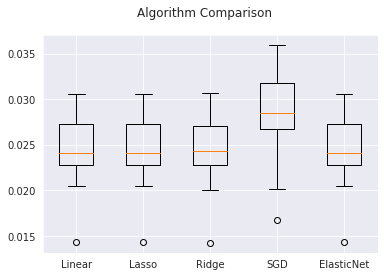

In [28]:
# prepare models
models = []
models.append(("Linear", linear_model.LinearRegression()))
models.append(("Lasso", linear_model.Lasso(alpha=0)))
models.append(('Ridge', linear_model.Ridge(alpha=0.759)))
models.append(('SGD', linear_model.SGDRegressor(max_iter=1000, tol=1e-3)))
models.append(("ElasticNet", linear_model.LassoLars(alpha=0)))

rmse_scorer = make_scorer(mean_squared_error)

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, training_dataset_X_scaled, training_dataset_Y_scaled.ravel(), cv=kfold, scoring=rmse_scorer)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    # boxplot algorithm comparison
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Choose ridge regression

In [29]:
X_train, X_test, y_train, y_test = train_test_split(training_dataset_X_scaled, training_dataset_Y_scaled, test_size=0.25)    

In [30]:
def validate_model(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    denormalized_prediction = min_max_scaler_Y.inverse_transform(prediction)
    denormalized_y = min_max_scaler_Y.inverse_transform(y_test)
    return mean_squared_error(denormalized_prediction, denormalized_y)

In [31]:
# linear
lin_result = validate_model(linear_model.LinearRegression())

# ridge 
ridge_result = validate_model(linear_model.Ridge(alpha=0.759, max_iter=500))

# lasso
# lasso_result = validate_model(linear_model.Lasso())

print(lin_result,
     ridge_result)

0.697521062355184 0.698136546752505


In [32]:
submission_model = linear_model.Ridge(alpha=0.759, max_iter=500)
submission_model.fit(training_dataset_X_scaled, training_dataset_Y_scaled)

predictions = submission_model.predict(test_dataset_X_scaled)
denormalized_prediction = min_max_scaler_Y.inverse_transform(predictions)

my_submission = pd.DataFrame({'id': test_df.id.to_numpy(), 'target': denormalized_prediction.flatten()})
my_submission.to_csv('submission.csv', index=False)